In [149]:
import torch

# Generate random binary spiking data: 128 time steps, 1000 neurons
# Rows are time steps and columns are neurons
spikes = torch.randint(0, 2, (128, 1000)).float()

# Calculate Mean Firing Rate
def mean_firing_rate(spikes):
    return spikes.mean(dim=0)

# Calculate Variability in Firing Rate (Coefficient of Variation of the ISI)
def variability_in_firing_rate(spikes):
    isi = []
    for neuron_spikes in spikes.t():  # transpose to iterate over neurons
        firing_times = torch.nonzero(neuron_spikes).flatten().to(torch.float32)
        if len(firing_times) > 1:
            intervals = torch.diff(firing_times)
            cv = intervals.std() / intervals.mean() if intervals.mean() > 0 else torch.tensor(0.)
        else:
            cv = torch.tensor(0.)  # No intervals can be calculated
        isi.append(cv)
    return torch.tensor(isi)

# Calculate Spike Count
def spike_count(spikes):
    return spikes.sum(dim=0)

# Calculate Peak Firing Rate (using a sliding window)
def peak_firing_rate(spikes, window_size = 5):
    if window_size > spikes.size(0):
        raise ValueError("Window size must be less than or equal to the number of time steps")

    # Calculate the firing rate for each neuron using a sliding window
    spikes = spikes.unsqueeze(0).transpose(1, 2)
    firing_rates = torch.nn.functional.avg_pool1d(spikes, kernel_size=window_size, stride=1)
    peak_firing_rates = firing_rates.max(dim=2).values.squeeze() # Find the peak firing rate for each neuron
    return peak_firing_rates

def temporal_binning(spike_raster, bin_size):
    """
    Perform temporal binning on the spike raster.

    Args:
        spike_raster (torch.Tensor): Tensor of shape (num_neurons, time_steps).
        bin_size (int): Number of time steps per bin.

    Returns:
        torch.Tensor: Binned spike raster with shape (num_neurons, num_bins).
    """
    num_neurons, time_steps = spike_raster.shape
    num_bins = time_steps // bin_size
    binned_raster = spike_raster[:, :num_bins * bin_size].reshape(num_neurons, num_bins, bin_size)
    binned_raster = binned_raster.sum(dim=2)  # Change to .mean(dim=2) for mean firing rate
    return binned_raster


# Apply Functions
mean_rates = mean_firing_rate(spikes)
variabilities = variability_in_firing_rate(spikes)
counts = spike_count(spikes)
peaks = peak_firing_rate(spikes)

# Create a dataset
features = torch.stack([mean_rates, variabilities, counts, peaks], dim=1)

In [131]:
from neucube.encoder import Delta
from neucube.validation import Pipeline
from neucube.sampler import SpikeCount
from neucube import Reservoir
import torch

In [132]:
import numpy as np
import pandas as pd

filenameslist = ['sam'+str(idx)+'_eeg.csv' for idx in range(1,61)]

dfs = []
for filename in filenameslist:
  dfs.append(pd.read_csv('./example_data/wrist_movement_eeg/'+filename, header=None))

fulldf = pd.concat(dfs)

labels = pd.read_csv('./example_data/wrist_movement_eeg/tar_class_labels.csv', header=None)
y = labels.values.flatten()

feat_names = pd.read_csv('./example_data/wrist_movement_eeg/feature_names_eeg.txt', header=None).values.flatten()
brain_coordinates = pd.read_csv('./example_data/wrist_movement_eeg/brain_coordinates.csv', header=None).values
eeg_mapping = pd.read_csv('./example_data/wrist_movement_eeg/eeg_mapping.csv', header=None).values

In [133]:
X = torch.tensor(fulldf.values.reshape(60,128,14))
encoder = Delta(threshold=0.8)
X = encoder.encode_dataset(X)
y = labels.values.flatten()

res = Reservoir(inputs=14, c=0.5, l=0.17)
res.summary()
w_latent = res.w_latent.cpu()
w_in = res.w_in.cpu()

Neurons                1000  
Reservoir connections  15971 
Input connections      724   
Device                 cuda:0


In [134]:
from tqdm import tqdm
batch_size, n_time, n_features = X.shape
n_neurons = res.n_neurons
spike_rec = torch.zeros(batch_size, n_time, n_neurons)
s = 0
mem_thr=30

for s in tqdm(range(X.shape[0])):
    a, b = torch.full((n_neurons,), 0.2, dtype=torch.float64), torch.full((n_neurons,), 0.2, dtype=torch.float64)
    c, d = torch.full((n_neurons,), -65, dtype=torch.float64), torch.full((n_neurons,), 2, dtype=torch.float64)
    mem_poten = torch.full((n_neurons,), -65, dtype=torch.float64)
    u_recvr = b*mem_poten

    spike_latent = torch.zeros(n_neurons)
    dt = 1  # Simulation time step
    T = n_time  # Total simulation time
    N = int(T / dt)  # Number of simulation steps

    mem_changes = []
    I_changes = []
    for k in range(N):
        spike_in = X[s,k,:]

        I = (torch.sum(w_in*spike_in, axis=1)+torch.sum(w_latent*spike_latent, axis=1))*550
        u_recvr = u_recvr + dt * (a * (b * mem_poten - u_recvr))
        mem_poten = mem_poten + dt * (0.04 * mem_poten**2 + 5 * mem_poten + 140 - u_recvr + I)

        mem_changes.append(mem_poten.clone())
        I_changes.append(I.clone())

        thres_met = mem_poten >= mem_thr
        mem_poten[thres_met] = c[thres_met]
        u_recvr[thres_met] = u_recvr[thres_met] + d[thres_met]

        spike_latent.fill_(0)
        spike_latent[thres_met] = 1

        spike_rec[s,k,:] = spike_latent

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:13<00:00,  4.52it/s]


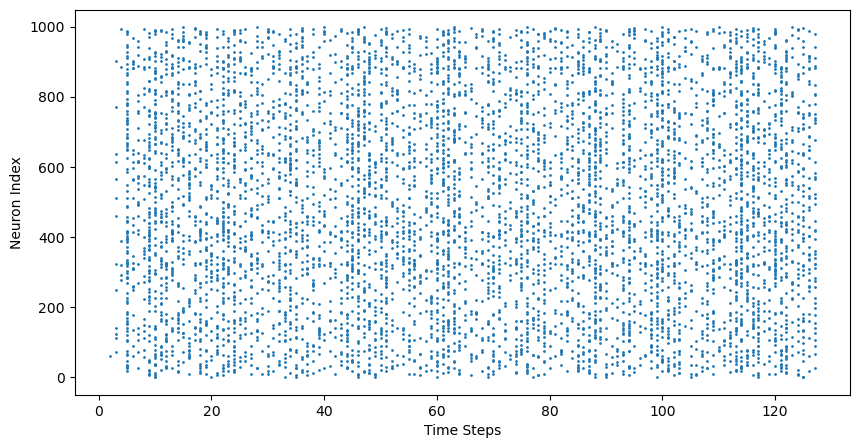

In [135]:
from neucube.visualise import spike_raster
spike_raster(spike_rec[0])

In [160]:
def temporal_binning(spike_raster, bin_size):
    num_bins = spike_raster.size(0) // bin_size
    binned_data = torch.zeros((num_bins, spike_raster.size(1)))
    for i in range(num_bins):
        start = i * bin_size
        end = start + bin_size
        binned_data[i] = spike_raster[start:end].sum(dim=0)    
    return binned_data
temporal_binning(spike_rec[0], 60)

tensor([[3., 0., 4.,  ..., 0., 4., 0.],
        [3., 0., 5.,  ..., 0., 5., 0.]])

In [202]:
def temporal_binning(spike_raster, bin_size):
    num_bins = spike_raster.size(0) // bin_size
    binned_data = spike_raster[:num_bins * bin_size].view(num_bins, bin_size, -1).sum(dim=1)
    return binned_data
temporal_binning(spike_rec[0], 10)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 1., 0.],
        ...,
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 1., 0.]])

In [208]:
temporal_binning(spike_rec[0], 10).shape

torch.Size([12, 1000])

In [210]:
spike_rec[0].shape

torch.Size([128, 1000])

In [207]:
temporal_binning(spike_rec[0], 10).flatten().shape

torch.Size([12000])

In [195]:
binned_data = spike_rec.unfold(1, 10, 10).sum(axis=3)
flat_binned = binned_data.view(binned_data.size(0), -1)

torch.Size([60, 12000])

In [147]:
state_vec = []
for s_train in spike_rec:
    flat_vec = temporal_binning(s_train, 10).flatten()
    state_vec.append(flat_vec)
state_vec = np.array(state_vec)

In [148]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

state_vec = np.array(state_vec)
num_folds = 10
kf = KFold(n_splits=num_folds)

true_labels = []
predicted_labels = []

for train_index, test_index in tqdm(kf.split(state_vec)):
    X_train_fold, X_test_fold = state_vec[train_index], state_vec[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    svm = SVC(kernel='linear')
    svm.fit(X_train_fold, y_train_fold)
    
    y_pred = svm.predict(X_test_fold)
    true_labels.extend(y_test_fold)
    predicted_labels.extend(y_pred)

accuracy = accuracy_score(true_labels, predicted_labels)
print("10-Fold Cross-Validation Accuracy:", accuracy)
print(confusion_matrix(true_labels, predicted_labels))

10it [00:00, 185.57it/s]

10-Fold Cross-Validation Accuracy: 0.6666666666666666
[[12  8  0]
 [ 8 11  1]
 [ 0  3 17]]


In [589]:
from tqdm import tqdm
import torch

batch_size, n_time, n_features = X.shape
n_neurons = res.n_neurons
dt = 1  # Reduced simulation time step
n_substeps = int(1 / dt)  # Number of sub-steps within each original time step
total_steps = n_time * n_substeps  # Total number of sub-steps

# Adjust the dimensions of spike_rec to include substeps
spike_rec = torch.zeros(batch_size, total_steps, n_neurons)
mem_thr = 30

for s in tqdm(range(batch_size)):
    a = torch.full((n_neurons,), 0.2, dtype=torch.float64)
    b = torch.full((n_neurons,), 0.2, dtype=torch.float64)
    c = torch.full((n_neurons,), -65, dtype=torch.float64)
    d = torch.full((n_neurons,), 2, dtype=torch.float64)
    mem_poten = torch.full((n_neurons,), -65, dtype=torch.float64)
    u_recvr = b * mem_poten

    spike_latent = torch.zeros(n_neurons)

    for t in range(n_time):
        for substep in range(n_substeps):
            step_index = t * n_substeps + substep  # Calculate the global step index

            spike_in = X[s, t, :]

            I = (torch.sum(w_in * spike_in, axis=1) + torch.sum(w_latent * spike_latent, axis=1)) * 550
            u_recvr = u_recvr + dt * (a * (b * mem_poten - u_recvr))
            mem_poten = mem_poten + dt * (0.04 * mem_poten**2 + 5 * mem_poten + 140 - u_recvr + I)

            thres_met = mem_poten >= mem_thr
            mem_poten[thres_met] = c[thres_met]
            u_recvr[thres_met] = u_recvr[thres_met] + d[thres_met]

            spike_latent.fill_(0)
            spike_latent[thres_met] = 1

            # Record the spikes at each substep
            spike_rec[s, step_index, :] = spike_latent

# Ensure that spike_rec is correctly shaped
spike_rec = spike_rec[:, :total_steps, :]

100%|██████████| 60/60 [01:15<00:00,  1.25s/it]


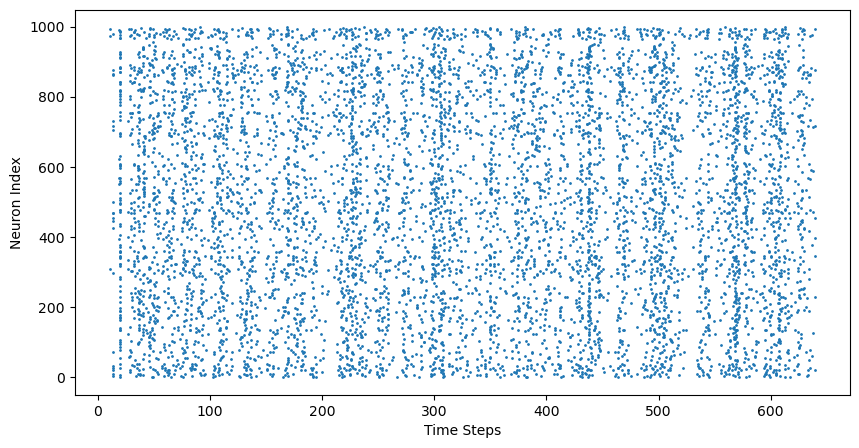

In [590]:
from neucube.visualise import spike_raster
spike_raster(spike_rec[0])

In [591]:
state_vec = []
for s_spikes in spike_rec:
    counts = spike_count(s_spikes)
    mean_rates = mean_firing_rate(s_spikes)
    variabilities = variability_in_firing_rate(s_spikes)
    peaks = peak_firing_rate(s_spikes)
    features = torch.stack([mean_rates, variabilities, counts, peaks], dim=1)
    # features = torch.stack([mean_rates], dim=1)
    state_vec.append(features.flatten().numpy())

In [592]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

state_vec = np.array(state_vec)
num_folds = 10
kf = KFold(n_splits=num_folds)

true_labels = []
predicted_labels = []

for train_index, test_index in tqdm(kf.split(state_vec)):
    X_train_fold, X_test_fold = state_vec[train_index], state_vec[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    svm = SVC(kernel='linear')
    svm.fit(X_train_fold, y_train_fold)
    
    y_pred = svm.predict(X_test_fold)
    true_labels.extend(y_test_fold)
    predicted_labels.extend(y_pred)

accuracy = accuracy_score(true_labels, predicted_labels)
print("10-Fold Cross-Validation Accuracy:", accuracy)
print(confusion_matrix(true_labels, predicted_labels))

10it [00:00, 102.67it/s]

10-Fold Cross-Validation Accuracy: 0.7666666666666667
[[16  4  0]
 [ 8 11  1]
 [ 0  1 19]]


In [43]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# Assuming state_vec and y are defined somewhere above this code snippet
state_vec = np.array(state_vec)
num_folds = 10
kf = KFold(n_splits=num_folds)

true_labels = []
predicted_labels = []

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))

for train_index, test_index in tqdm(kf.split(state_vec)):
    X_train_fold, X_test_fold = state_vec[train_index], state_vec[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Fit MinMaxScaler only on the training data
    scaler.fit(X_train_fold)

    # Transform both training and test data
    X_train_fold_scaled = scaler.transform(X_train_fold)
    X_test_fold_scaled = scaler.transform(X_test_fold)

    svm = SVC(kernel='linear', C=1)
    svm.fit(X_train_fold_scaled, y_train_fold)
    
    y_pred = svm.predict(X_test_fold_scaled)
    true_labels.extend(y_test_fold)
    predicted_labels.extend(y_pred)

accuracy = accuracy_score(true_labels, predicted_labels)
print("10-Fold Cross-Validation Accuracy:", accuracy)
print(confusion_matrix(true_labels, predicted_labels))

10it [00:00, 27.56it/s]

10-Fold Cross-Validation Accuracy: 0.03333333333333333
[[ 0  0 20]
 [ 5  0 15]
 [15  3  2]]


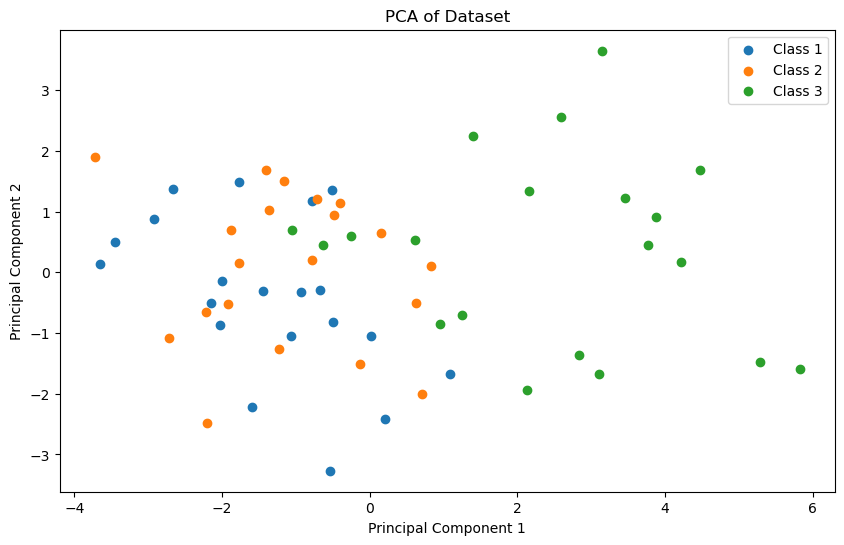

In [526]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Assuming state_vec is your data and y is your target labels

# Perform normalization
# scaler = StandardScaler()  # or use MinMaxScaler()
scaler = MinMaxScaler()  # Choose appropriate scaler
state_vec_normalized = scaler.fit_transform(state_vec)

# Perform PCA
pca = PCA(n_components=2)  # You can change the number of components as needed
pca_result = pca.fit_transform(state_vec_normalized)

# Plotting
plt.figure(figsize=(10, 6))
for label in np.unique(y):
    plt.scatter(pca_result[y == label, 0], pca_result[y == label, 1], label=f'Class {label}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Dataset')
plt.legend()
plt.show()